In [2]:
from task2vec import Task2Vec
from models import get_model
import datasets
import task_similarity
import argparse
import torch
import torch.nn.functional as F
import torchvision.transforms as tt
import torch.nn as nn
from tqdm import tqdm
from synbols_utils import Synbols
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

seed = 123


In [1]:
def data_pipeline(selected_languages, selected_attrs, filter = True):

    def select(data, langs, attrs):
        select = data[(data['lang'].isin(langs)) & (data['attr'].isin(attrs))]
        return select
    def merge(saved, ref):
        data = pd.DataFrame(saved)
        data['lang'] = ref['lang']
        data['attr'] = ref['attr']
        data['name'] = ref['name']
        return data


    saved = torch.load('all.pt')
    seed = 123
    ref = pd.read_csv('ref.csv', index_col = 0)
    data = merge(saved, ref)
    if filter:
        data = select(data=data, langs = selected_languages, attrs = selected_attrs)
    Z = [x.hessian for x in data[0].to_numpy()]
    return Z, data.reset_index(drop=True)

In [3]:

# Add Task2Vec as part of the SingleHead Class

class AttentionNet(nn.Module):
    """Soft-Attention on the Embedding z"""
    
    def __init__(self, input_dim, latent_dim):
        super(Attention, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.attention = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.ReLU(inplace=True), #FIXME Try Tanh as well
            nn.Linear(latent_dim,input_dim)
        )

    def forward(self, x):
        x = self.attention(x)
        return F.softmax(x)


class AttentionRawList(nn.Module):
    """Attention through Raw Params
            Input: Param shape, No of Params"""
    def __init__(self, shape, N):
        super(AttentionRaw, self).__init__()
        self.params = nn.ParameterList([nn.Parameter(torch.randn((shape))) for _ in range(N)])

    def __getitem__(self, index):
        return self.params[index]

    def forward(self, index, x):
        # Weighted/Atttention on x using Attention 'i'
        return self.params[index] * x 

class AttentionRaw(nn.Module):
    """Attention through Raw Params
            Input: Param shape, No of Params"""
    def __init__(self, shape):
        super(AttentionRaw, self).__init__()
        # Attention Params: Shape N_attn, M as N Attentions of dimension M 
        self.params = nn.Parameter(torch.randn(N, task2vec_dim), requires_grad = True)

    def forward(self, x):
        # Weighted/Atttention on x using Attention 'i'
        # X shape: N_z, M, Params shape: N_attn, M
        # Do Element wise multiplication
        soft = F.softmax(self.params, dim = -1)
        return torch.mul(torch.unsqueeze(soft, 1), x) 

Z = [z.hessian for z in saved]
task2vec_dim = Z[0].shape[0]
latent_dim = 128
M = len(Z) # No of Task vectors
Z_tensor = torch.tensor(Z)

In [4]:
def cos_sim(A,B, eps=1e-8, ):
    A_norm = A.norm(dim = -1, keepdim = True)
    B_norm = B.norm(dim = -1, keepdim = True)
    A_norm = torch.maximum(A_norm, eps * torch.ones(A_norm.shape))
    B_norm = torch.maximum(B_norm, eps * torch.ones(B_norm.shape))
    A = torch.div(A,A_norm)
    B = torch.div(B,B_norm)
    return torch.mm(A,B.T)
def norm_unitvectors(M, eps = 1e-8):
    M_norm = M.norm(dim = -1, keepdim = True)
    M_norm = torch.maximum(M_norm, eps * torch.ones(M_norm.shape))
    return torch.div(M, M_norm)
def positives(Attrs):
    M = norm_unitvectors(Attrs)
    M_trans = M.transpose(1,2)
    return torch.bmm(M, M_trans)
def positive_loss(Attrs, log = True):
    if log:
        x = -torch.log(positives(Attrs).flatten())
    else:
        x = 1 - positives(Attrs).flatten().to(torch.float16)
    return x.sum()
def negative_loss(Attrs):
    """For two attributes
    """
    neg_pair = cos_sim(Attrs[0], Attrs[1])
    return (neg_pair.flatten()).sum()

In [ ]:
def contrastive_loss(Attrs):
    

In [5]:
def train(attns, Z, optimizer, gamma = 2):
    attns.train()
    attrs = attns(Z)
    pos_loss = positive_loss(attrs)
    neg_loss = negative_loss(attrs)
    loss =  pos_loss + neg_loss * gamma
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return pos_loss, neg_loss, loss

In [6]:
filter = False
selected_languages = ['malayalam', 'chinese', 'tamil'] #['tamil','malayalam', 'japanese','chinese']
selected_attrs = ['scale', 'gradient', 'camouflage','std'] # 'scaled',
Z, data = data_pipeline(selected_languages, selected_attrs, filter = filter)
Z_tensor = torch.tensor(Z)
task2vec_dim = Z_tensor.shape[1]
M = Z_tensor.shape[0] # No of Task vectors
latent_dim = 128

In [7]:
N = 2 # No of attributes
attns = AttentionRaw((N, task2vec_dim)) #AttentionRawList(task2vec_dim, N)

In [8]:
n_epochs = 1000
gamma = 1.
optimizer = torch.optim.Adam(attns.parameters(), lr = 1e-1)
for epoch in range(n_epochs):
    pos_loss, neg_loss, total_loss = train(attns, Z_tensor, optimizer, gamma = gamma)
    if epoch%100 == 0:
        print(f"Epoch: {epoch}, pos_loss: {pos_loss}, neg_loss: {neg_loss}, total_loss: {total_loss}")

Epoch: 0, pos_loss: 2445.5244140625, neg_loss: 6653.921875, total_loss: 9099.4462890625
Epoch: 100, pos_loss: 2.776606798171997, neg_loss: 0.45318588614463806, total_loss: 3.229792594909668
Epoch: 200, pos_loss: 1.525010108947754, neg_loss: 0.26377251744270325, total_loss: 1.7887825965881348
Epoch: 300, pos_loss: 0.9759643077850342, neg_loss: 0.1856032907962799, total_loss: 1.1615675687789917
Epoch: 400, pos_loss: 0.6779933571815491, neg_loss: 0.1401473879814148, total_loss: 0.8181407451629639
Epoch: 500, pos_loss: 0.503119707107544, neg_loss: 0.11076443642377853, total_loss: 0.6138841509819031
Epoch: 600, pos_loss: 0.3931814730167389, neg_loss: 0.09035775810480118, total_loss: 0.4835392236709595
Epoch: 700, pos_loss: 0.3025840222835541, neg_loss: 0.07546477764844894, total_loss: 0.3780488073825836
Epoch: 800, pos_loss: 0.25396886467933655, neg_loss: 0.06416783481836319, total_loss: 0.31813669204711914
Epoch: 900, pos_loss: 0.20568610727787018, neg_loss: 0.05535999685525894, total_loss

In [9]:
attrs = attns(Z_tensor)
task_attributes = attrs.transpose(0,1)
task_attribute_magnitudes = task_attributes.norm(dim = -1)
final = pd.DataFrame(task_attribute_magnitudes.detach().numpy(), columns = ['x','y'])
data['x'] = final['x']
data['y'] = final['y']

In [10]:
task_attributes.shape

torch.Size([135, 2, 13824])

In [11]:
attrs.shape

torch.Size([2, 135, 13824])

In [12]:
attrs[0].shape

torch.Size([135, 13824])

In [13]:
cos_sim(attrs[0], attrs[1])

tensor([[2.4021e-06, 2.1151e-06, 2.7041e-06,  ..., 2.3842e-06, 2.0509e-06,
         2.8874e-06],
        [2.9151e-06, 2.6614e-06, 3.2499e-06,  ..., 2.9284e-06, 2.5765e-06,
         3.4382e-06],
        [1.9869e-06, 1.7326e-06, 2.3559e-06,  ..., 2.0040e-06, 1.6596e-06,
         2.4498e-06],
        ...,
        [2.3324e-06, 2.0786e-06, 2.6682e-06,  ..., 2.3645e-06, 2.0016e-06,
         2.8161e-06],
        [3.1942e-06, 2.9116e-06, 3.5177e-06,  ..., 3.1866e-06, 2.8609e-06,
         3.7364e-06],
        [2.0432e-06, 1.7654e-06, 2.3594e-06,  ..., 2.0370e-06, 1.6977e-06,
         2.5831e-06]], grad_fn=<MmBackward>)

In [14]:
cos_sim(attrs[0], attrs[1]).shape

torch.Size([135, 135])

In [15]:
attns.params.shape

torch.Size([2, 13824])

In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = PCA(n_components=2, random_state=seed)
X_2d = tsne.fit_transform(final)


In [17]:
data

,0,lang,attr,name,x,y
0,<task2vec.Embedding object at 0x7f791a00b710>,khmer,italic,khmer_italic.h5py,0.000016,0.000009
1,<task2vec.Embedding object at 0x7f791a00b850>,telugu,natural,telugu_natural.h5py,0.000016,0.000013
2,<task2vec.Embedding object at 0x7f791a00b950>,gujarati,italic,gujarati_italic.h5py,0.000015,0.000006
3,<task2vec.Embedding object at 0x7f791a00ba10>,chinese,gradient,chinese_gradient.h5py,0.000010,0.000008
4,<task2vec.Embedding object at 0x7f791a00bb50>,tamil,italic,tamil_italic.h5py,0.000012,0.000007
...,...,...,...,...,...,...
130,<task2vec.Embedding object at 0x7f7919fb6ed0>,bangla,natural,bangla_natural.h5py,0.000016,0.000011
131,<task2vec.Embedding object at 0x7f7919fba050>,english,translated,english_translated.h5py,0.000031,0.000010
132,<task2vec.Embedding object at 0x7f7919fba190>,russian,natural,russian_natural.h5py,0.000022,0.000012
133,<task2vec.Embedding object at 0x7f7919fba2d0>,thai,italic,thai_italic.h5py,0.000012,0.000011


sns.catplot(x="x", y="y", hue="attr",
            col="lang", aspect=.7, data = data)
            #kind="swarm", data=data)

In [20]:
sns.set(rc={'figure.figsize':(15,15)})


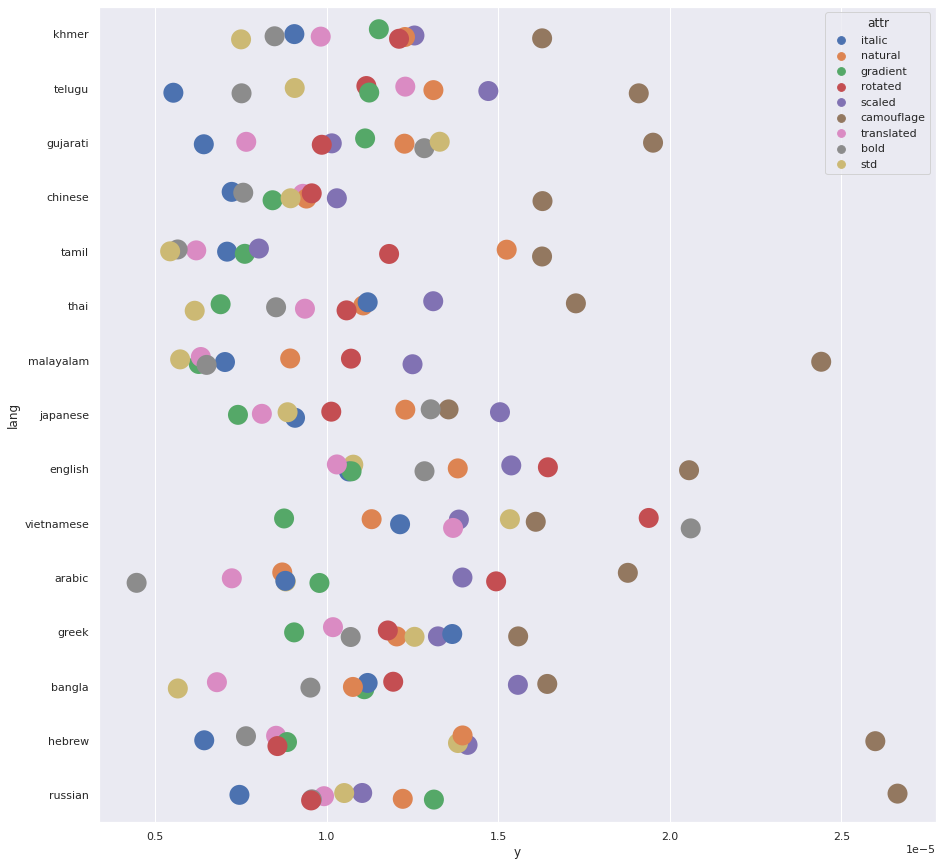

In [21]:
ax = sns.stripplot(x="y", y="lang", hue = "attr", data=data, s=20)

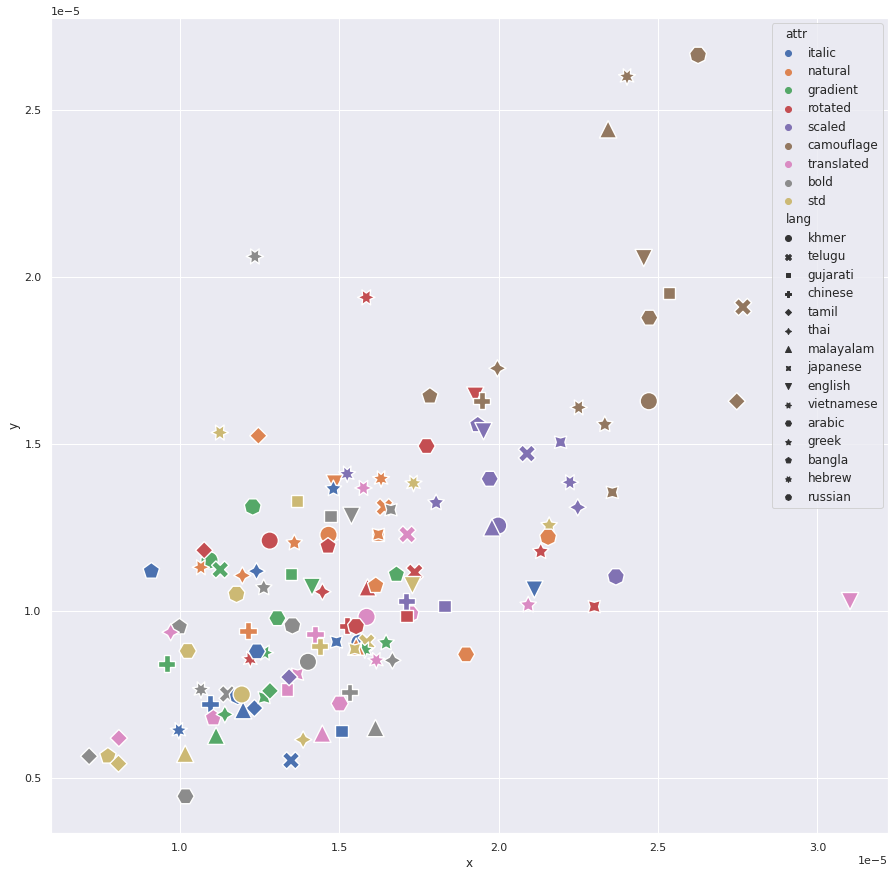

In [24]:
#plt.figure(figsize = (15,15))
sns.scatterplot(data=data, x="x", y="y", hue = "attr", style="lang", s = 300)

In [143]:
#Attentions.cuda()
Z_loader = torch.utils.data.DataLoader(Z, batch_size = len(Z))
optimizer = torch.optim.Adam(attns.parameters())

attns_z_matrix = attns(Z_tensor)

import numpy as np
attns_query = torch.mm(attns.params, Z_tensor.T) / np.sqrt(1384)

batch_size = 1024
q_len = 32
v_len = 32
hidden_dim = 128
k_len = 32
query = torch.randn((batch_size, q_len, hidden_dim)) # q_len, hidden_dim @ hidden_dim, k_len 
key = torch.randn((batch_size, k_len, hidden_dim))
value = torch.randn((batch_size, v_len, hidden_dim))

score = torch.bmm(query, key.transpose(1, 2)) / np.sqrt(hidden_dim)
attn = F.softmax(score, -1)
context = torch.bmm(attn, value)

In [63]:
for _, batch in enumerate(Z_loader):
    break

In [64]:
attrs = attns(batch)


def _similarity_matrix(attrs, epsilon = 1e-8):
    norm = attrs.norm(dim = -1, keepdim = True)
    norm = torch.maximum(norm, 1e-8 * torch.ones(norm.shape))
    attrs = attrs / norm
    temp = attrs.view(attrs.shape[0], attrs.shape[1],1,1,attrs.shape[2])
    similarity_matrix = torch.mul(temp,attrs).sum(axis = -1)
    return similarity_matrix

similarity_matrix = _similarity_matrix(attrs)

## Sample 

In [110]:
Attns = [[0.5, 0.5], [0.2, 0.8], [0.1, 0.9]] # Three Attns 3x2
Z = [[1,2],[3,4],[5,6],[7,8],[9,10]] # 5 z vectors. 5 x 2
Attns = torch.tensor(Attns)
Z = torch.tensor(Z)
print(f"Attns: {Attns.shape}, Z: {Z.shape}")

Attns: torch.Size([3, 2]), Z: torch.Size([5, 2])


In [111]:
def forward_pass(Attns, Z):
    return torch.mul(torch.unsqueeze(Attns, 1), Z) 

In [112]:
Attrs = forward_pass(Attns, Z)
Attrs.shape

torch.Size([3, 5, 2])

In [9]:
def cos_sim(A,B, eps=1e-8, ):
    A_norm = A.norm(dim = -1, keepdim = True)
    B_norm = B.norm(dim = -1, keepdim = True)
    A_norm = torch.maximum(A_norm, eps * torch.ones(A_norm.shape))
    B_norm = torch.maximum(B_norm, eps * torch.ones(B_norm.shape))
    A = torch.div(A,A_norm)
    B = torch.div(B,B_norm)
    return torch.mm(A,B.T)
cos_sim(Attrs[0],Attrs[0]).flatten().contiguous()

tensor([1.0000, 0.9839, 0.9734, 0.9676, 0.9640, 0.9839, 1.0000, 0.9987, 0.9972,
        0.9960, 0.9734, 0.9987, 1.0000, 0.9997, 0.9993, 0.9676, 0.9972, 0.9997,
        1.0000, 0.9999, 0.9640, 0.9960, 0.9993, 0.9999, 1.0000])

In [ ]:
def all(attrs):
    return torch.matmul(attrs.unsqueeze(-1).transpose(2,3), attrs.unsqueeze(-1)).squeeze()

In [118]:
Attrs.unsqueeze(-1).transpose(2,3).shape

torch.Size([3, 5, 1, 2])

In [116]:
Attrs.unsqueeze(-1).shape

torch.Size([3, 5, 2, 1])

In [114]:
Attrs

tensor([[[0.5000, 1.0000],
         [1.5000, 2.0000],
         [2.5000, 3.0000],
         [3.5000, 4.0000],
         [4.5000, 5.0000]],

        [[0.2000, 1.6000],
         [0.6000, 3.2000],
         [1.0000, 4.8000],
         [1.4000, 6.4000],
         [1.8000, 8.0000]],

        [[0.1000, 1.8000],
         [0.3000, 3.6000],
         [0.5000, 5.4000],
         [0.7000, 7.2000],
         [0.9000, 9.0000]]])

In [52]:
positive_loss()

In [79]:
orthogonality_loss =  

In [45]:
# Positives
# sim(Attr[i], Attr[j]) = 1 | -1 
# |sim(Attr[i], Attr[j])| = 1
# for all i, and i = j

# Negatives or Zero
#   Negatives:
#       sim(Attr[i], Attr[j]) for all i=/j

# or induce Orthogonality as   Zero:
#   sim(Attr[i], Attr[j]) = 0



def positives(Attrs):
    """
    """
    

tensor([0.9430, 0.9615, 0.9668, 0.9693, 0.9708, 0.8682, 0.8969, 0.9056, 0.9097,
        0.9122, 0.8417, 0.8730, 0.8826, 0.8873, 0.8900, 0.8284, 0.8610, 0.8711,
        0.8759, 0.8788, 0.8205, 0.8538, 0.8641, 0.8691, 0.8720])

In [59]:
cos_matrix = _similarity_matrix(Attrs)
cos_matrix.shape

torch.Size([3, 5, 3, 5])

In [64]:
cos_matrix[0][:][0][:]

tensor([[1.0000, 0.9839, 0.9734, 0.9676, 0.9640],
        [0.9430, 0.9615, 0.9668, 0.9693, 0.9708],
        [0.9179, 0.9285, 0.9318, 0.9335, 0.9345]])

In [25]:
i = 0
j = 6
k = 6
similarity_matrix[i][:][i][:].shape

torch.Size([4, 135])

In [ ]:
def positives(sim_matrix, i):
    """
        For all j,k: do summation of cos similarities across matrix for given i
        
        Note: mat[i][j][i][k] represents sim(att[i][j], att[i][k])
        So, for i'th attribute, positives are:
            SUM_j,k mat[i][j][i][k]
    """

In [ ]:
def alignment_loss(similarity_matrix):
    

In [ ]:
for epoch in range(n_epochs):
    print(f"Epoch:{epoch}")
    attentions.train()
    for batch_ix, Z in enumerate(Z_loader):
        optimizer.zero_grad()
        

In [ ]:

for epoch in range(args.epochs):
    print("Epoch", epoch)
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        x, y = batch
        x = x.cuda()
        y = y.cuda()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()

    print("train_loss", float(loss))
    with torch.no_grad():
        model.eval()
        hits = 0
        total = 0
        for batch in tqdm(val_loader):
            x, y = batch
            x = x.cuda()
            y = y.cuda()
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            hits += (logits.argmax(-1) == y).float().sum().item()
            total += x.size(0)

    print("val_loss", float(loss), "val_accuracy", hits / total)
